## Import packages

In [1]:
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds

### Load the dataset

In [2]:
fmnist_dataset, fmnist_info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True)

### Preprocessing

In [3]:
fmnist_train, fmnist_test = fmnist_dataset['train'], fmnist_dataset['test']

num_validation_samples = 0.1 * fmnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = fmnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

# normally, we would like to scale our data in some way to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
# let's define a function called: scale, that will take an Horses_or_humans image and its label
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

scaled_train_and_validation_data = fmnist_train.map(scale)

test_data = fmnist_test.map(scale)

In [4]:
BUFFER_SIZE = 10000

shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

validation_data = shuffled_train_and_validation_data.take(num_validation_samples)
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

BATCH_SIZE = 500

# we can also take advantage of the occasion to batch the train data
# this would be very helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

validation_inputs, validation_targets = next(iter(validation_data))

In [5]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='tanh'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                   ])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

NUM_EPOCHS = 10

history = model.fit(train_data,
          epochs = NUM_EPOCHS,
          callbacks=[early_stopping],
          validation_data=(validation_inputs, validation_targets),
          validation_steps=1,
          verbose=2)

Epoch 1/10
108/108 - 67s - loss: 0.7253 - accuracy: 0.7401 - val_loss: 0.4428 - val_accuracy: 0.8442
Epoch 2/10
108/108 - 65s - loss: 0.4340 - accuracy: 0.8420 - val_loss: 0.3784 - val_accuracy: 0.8700
Epoch 3/10
108/108 - 62s - loss: 0.3750 - accuracy: 0.8650 - val_loss: 0.3248 - val_accuracy: 0.8880
Epoch 4/10
108/108 - 63s - loss: 0.3294 - accuracy: 0.8808 - val_loss: 0.2994 - val_accuracy: 0.8962
Epoch 5/10
108/108 - 63s - loss: 0.3067 - accuracy: 0.8885 - val_loss: 0.2799 - val_accuracy: 0.9005
Epoch 6/10
108/108 - 63s - loss: 0.2889 - accuracy: 0.8945 - val_loss: 0.2738 - val_accuracy: 0.9033
Epoch 7/10
108/108 - 63s - loss: 0.2679 - accuracy: 0.9015 - val_loss: 0.2771 - val_accuracy: 0.9010
Epoch 8/10
108/108 - 63s - loss: 0.2573 - accuracy: 0.9046 - val_loss: 0.2426 - val_accuracy: 0.9108
Epoch 9/10
108/108 - 64s - loss: 0.2412 - accuracy: 0.9115 - val_loss: 0.2434 - val_accuracy: 0.9068
Epoch 10/10
108/108 - 67s - loss: 0.2298 - accuracy: 0.9162 - val_loss: 0.2248 - val_accura

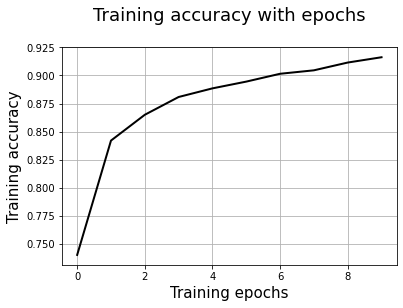

In [9]:
plt.plot(history.history['accuracy'],c='k',lw=2)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 4ms/step - loss: 0.2781 - accuracy: 0.8984


The end result is not as satisfying as it should be. One of the reasons behind this can be because I didn't reshape the dataset into a 4D list of 60,000x28x28x1.

Even if I do try that the system takes too long to compute a single epoch. You can try this on your own and might end up with a better result.